In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv('../input/advertising.csv')

In [3]:
df.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


In [4]:
df.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


Looks like the mean values are on different orders. We'll probably need to scale the features later!

In [5]:
np.sum(df.isnull(), axis = 0)

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               0
dtype: int64

Thankfully, no missing values!

### EDA

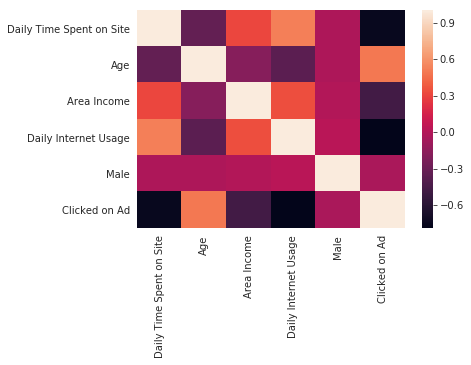

In [6]:
sns.heatmap(df.corr());

From the heatmap, the daily time spend on site and the daily internet usage appear to be the features that are most correlated. Let's plot a scatterplot to see how it looks like!

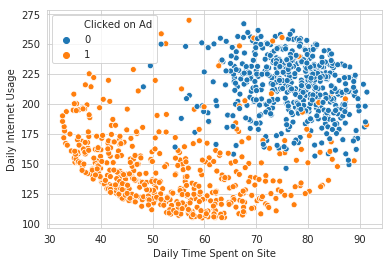

In [7]:
sns.scatterplot(x = 'Daily Time Spent on Site', y = 'Daily Internet Usage', data = df, hue = 'Clicked on Ad');

Interesting! Just by considering these two features it looks like we have quite a clear separation of categories already! Not only that, the boundary appears to be quite linear as well. However, there are some outliers (the orange points) that are in the blue region, but not vice-versa (trying to classify these outliers correctly will be difficult task indeed)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


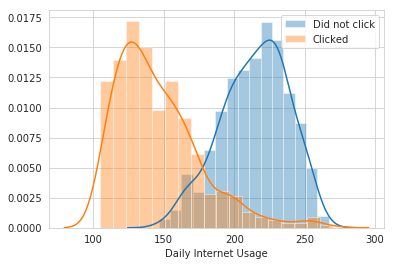

In [8]:
sns.distplot(df[df['Clicked on Ad'] == 0]['Daily Internet Usage'], label = 'Did not click');
sns.distplot(df[df['Clicked on Ad'] == 1]['Daily Internet Usage'], label = 'Clicked');
plt.legend();

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


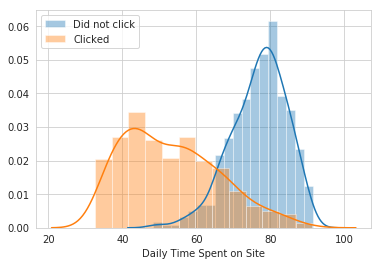

In [9]:
sns.distplot(df[df['Clicked on Ad'] == 0]['Daily Time Spent on Site'], label = 'Did not click');
sns.distplot(df[df['Clicked on Ad'] == 1]['Daily Time Spent on Site'], label = 'Clicked');
plt.legend();

The next most correlated feature is age, let's see if there is a big difference between the two categories, through a box plot

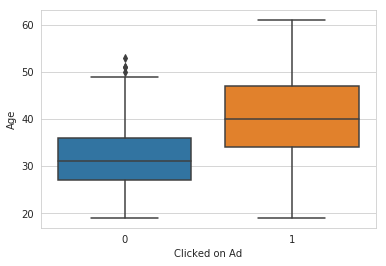

In [10]:
sns.boxplot(x = 'Clicked on Ad', y = 'Age', data = df);

There seems to be a correlation here as well, older people seem to click on the ad more often!


### Classification (Logistic Regression)

Let's now begin our classification task. We'll begin with a simple logistic regression to give us a linear decision boundary

In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

We'll work with just the 2 daily time features explored previously as they already provide us with quite a clear distinction.

In [12]:
x = df[['Daily Time Spent on Site', 'Daily Internet Usage']]
y = df['Clicked on Ad']

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)

In [13]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression())
])

In [14]:
pipe.fit(x_train,y_train)
y_pred = pipe.predict(x_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Let's see how our model does!

In [15]:
from sklearn.metrics import classification_report as cr, confusion_matrix as cm

In [16]:
print(cm(y_test,y_pred))
print(cr(y_test,y_pred))

[[145   2]
 [ 11 142]]
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       147
           1       0.99      0.93      0.96       153

   micro avg       0.96      0.96      0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



Wow! This is actually pretty amazing already! This makes me wonder if the data is from real-life or not =O

Nevertheless, as an exercise, let's try to plot out the decision boundary using just the 2 daily times features!

In [17]:
def plotBoundary(x,classifier):
    x1_max = np.max(x['Daily Time Spent on Site']) + 1
    x1_min = np.min(x['Daily Time Spent on Site']) - 1
    x2_max = np.max(x['Daily Internet Usage']) + 1
    x2_min = np.min(x['Daily Internet Usage']) - 1

    xx1,xx2 = np.meshgrid( np.arange(x1_min,x1_max,0.1), np.arange(x2_min, x2_max,0.1))
    features = np.array([xx1.ravel(), xx2.ravel()]).T
    predictions = classifier.predict(features).reshape(xx1.shape)
    plt.contour(xx1,xx2,predictions);

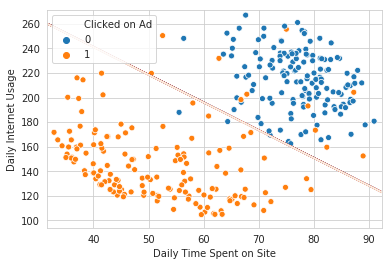

In [18]:
plotBoundary(x,pipe)
sns.scatterplot(x = 'Daily Time Spent on Site', y = 'Daily Internet Usage', data = x_test, hue = y_test);

As expected, we managed to capture most of the points, except for the outliers mentioned previously. The linear decision boundary appears to be a pretty good fit!

### Classification (KNN)

Let's try to use the K Nearest Neighbors Classifier this time!

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [20]:
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])

param_grid = {
    'clf__n_neighbors': list(range(5,55,5))
}

grid = GridSearchCV(pipe2, param_grid = param_grid, cv = 5)


In [21]:
grid.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [22]:
print(grid.best_params_)
print(grid.best_score_)

{'clf__n_neighbors': 30}
0.9542857142857143


Looks like 25 neighbors is the best choice out of the given range! 

In [23]:
y_pred2 = grid.predict(x_test)
print(cm(y_test,y_pred2))
print(cr(y_test,y_pred2))

[[146   1]
 [ 15 138]]
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       147
           1       0.99      0.90      0.95       153

   micro avg       0.95      0.95      0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300



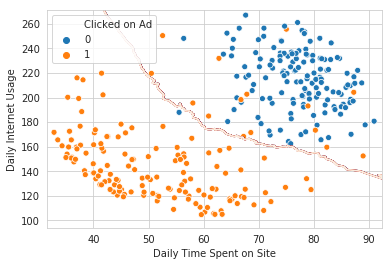

In [24]:
plotBoundary(x,grid)
sns.scatterplot(x = 'Daily Time Spent on Site', y = 'Daily Internet Usage', data = x_test, hue = y_test);

That's a cool-looking boundary =) But unfortunately, this has caused us to miss out some points near the boundary (compare this against the logistic regression case and we see that there are a few orange points very close to the boundary; they were classified correctly previously, but now they are incorrectly classified)

Overall, I think this is a pretty kind dataset because we didn't need to do any data cleaning, and some features were already strongly correlated so it was pretty easy to pick out the important ones! Hope you enjoyed the read!